# Toxic Comment Classification

In [1]:
!nvidia-smi

Sun Sep 29 08:17:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install pytorch-lightning==2.4.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 31.6 MB/s eta 0:00:00


In [5]:
!pip install transformers==4.44.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 23.7 MB/s eta 0:00:00


In [6]:
!pip install torchmetrics==1.4.2 --quiet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torchmetrics import F1Score, Precision, Recall, Accuracy, AUROC

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [8]:
from google.colab import files
uploaded = files.upload()

Saving clean_data.csv to clean_data.csv
Saving test_df.csv to test_df.csv


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
df = pd.read_csv("clean_data.csv").drop(columns=['Unnamed: 0', 'comment_length', 'id'])
df.shape

(142695, 8)

Maxx token length is 128, which is long enought to cover 75% of comments, small enought for fast model training.

In [11]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_labels = len(LABEL_COLUMNS)

MAX_TOKEN_COUNT = 128
BATCH_SIZE = 32


MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, clean_up_tokenization_spaces=True)



class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        # Ensure all texts are strings
        self.texts = [str(text) if not isinstance(text, str) else text for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Dataloaders
## Train, Validation
Train and Validation are split 90/10 with stratification. These sets were cleaned in EDA, for ensuring model learns only relevent information.

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df['one_hot_labels'] = list(df[LABEL_COLUMNS].values)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_flag,one_hot_labels
0,featured article think links incorporated feat...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,read article,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,article interesting reasons trying promote con...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,dyk nom know updated article lucy jane bledsoe...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,want ill try refactor page removing gts remark...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


Stratifying the datasets

In [13]:
df = pd.concat([df[df['toxic_flag'] == 1], df[df['toxic_flag'] == 0].sample((70000 - df[df['toxic_flag']
               == 1]['toxic_flag'].sum()), random_state=42)]).drop(columns='toxic_flag').reset_index(drop=True)

In [14]:
df['strat_label'] = df['one_hot_labels'].apply(lambda x: '-'.join(map(str, x)))

label_counts = df['strat_label'].value_counts()
print("Class distribution:\n", label_counts)

if (label_counts < 2).any():
    print("Warning: At least one class has fewer than 2 instances.")

    from sklearn.model_selection import train_test_split

    strat_train_set, strat_test_set = train_test_split(df, test_size=0.1, random_state=42)

else:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(df, df['strat_label']):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]

Class distribution:
 strat_label
0-0-0-0-0-0    56295
1-0-0-0-0-0     4771
1-0-1-0-1-0     3149
1-0-1-0-0-0     1415
1-0-0-0-1-0      999
1-1-1-0-1-0      760
1-0-1-0-1-1      479
0-0-1-0-0-0      280
0-0-0-0-1-0      273
1-0-1-1-1-0      236
1-1-1-0-1-1      197
0-0-1-0-1-0      165
1-0-0-1-0-0      134
1-0-1-1-1-1      123
1-1-1-0-0-0      105
1-0-0-0-0-1       91
1-1-1-1-1-0       91
1-0-0-0-1-1       88
1-1-1-1-1-1       58
0-0-0-0-0-1       50
0-0-0-1-0-0       43
1-1-0-0-0-0       29
1-0-1-0-0-1       26
0-0-0-0-1-1       26
1-0-0-1-1-0       17
1-1-0-1-0-0       15
0-0-1-0-1-1       15
1-0-1-1-0-0       15
1-0-0-1-0-1       12
1-1-0-0-1-0        7
0-0-1-1-1-0        6
0-0-1-1-0-0        6
1-0-0-1-1-1        5
1-1-1-1-0-0        4
1-1-0-1-1-0        3
0-0-1-0-0-1        3
1-1-0-1-0-1        3
1-1-1-0-0-1        2
0-0-0-1-1-0        2
1-1-0-0-1-1        1
1-1-0-0-0-1        1
Name: count, dtype: int64


In [15]:
train_df = strat_train_set
val_df = strat_test_set

In [16]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels,strat_label
42878,fcb done thats look tight succinct plots accur...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",0-0-0-0-0-0
5946,haha moron told shut get unblocked im gonna as...,1,0,1,0,1,0,"[1, 0, 1, 0, 1, 0]",1-0-1-0-1-0
33058,geocities says female ostrich hen wwwemusupply...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",0-0-0-0-0-0
34692,hey carnildo looking latest conrtibs noticed m...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",0-0-0-0-0-0
59232,able use account accidently left account logge...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]",0-0-0-0-0-0


Training and Validation data is loaded by Sequential Sampler, while Test (below) will be loaded by Random Sampler

In [17]:
def sequential_loader(df, tokenizer, max_length=MAX_TOKEN_COUNT, batch_size=BATCH_SIZE):
    texts = df['comment_text'].tolist()
    labels = np.stack(df['one_hot_labels'].tolist())

    dataset = TextDataset(texts, labels, tokenizer, max_length)
    sampler = SequentialSampler(dataset)

    loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size
    )

    return loader

train_loader = sequential_loader(train_df, tokenizer)
val_loader = sequential_loader(val_df, tokenizer)


torch.save(val_loader, 'validation_data_loader')
torch.save(train_loader, 'train_data_loader')

## Test data
Test data was prepared in EDA part.

In [18]:
test_path = r"test_df.csv"
test_df = pd.read_csv(test_path).drop(columns='Unnamed: 0')
test_df['one_hot_labels'] = list(test_df[LABEL_COLUMNS].values)
test_df = test_df.drop(columns=(['id', 'language']))
test_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,thank understanding think highly would revert ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,dear god site horrible,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,somebody invariably try add religion really me...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,says right type type institution needed case t...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,adding new product list make sure relevant add...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [26]:
test_df.shape

(62924, 8)

A sample of 10000 was choosen for Test dataset. The distribution of toxic comments is similar to training set.

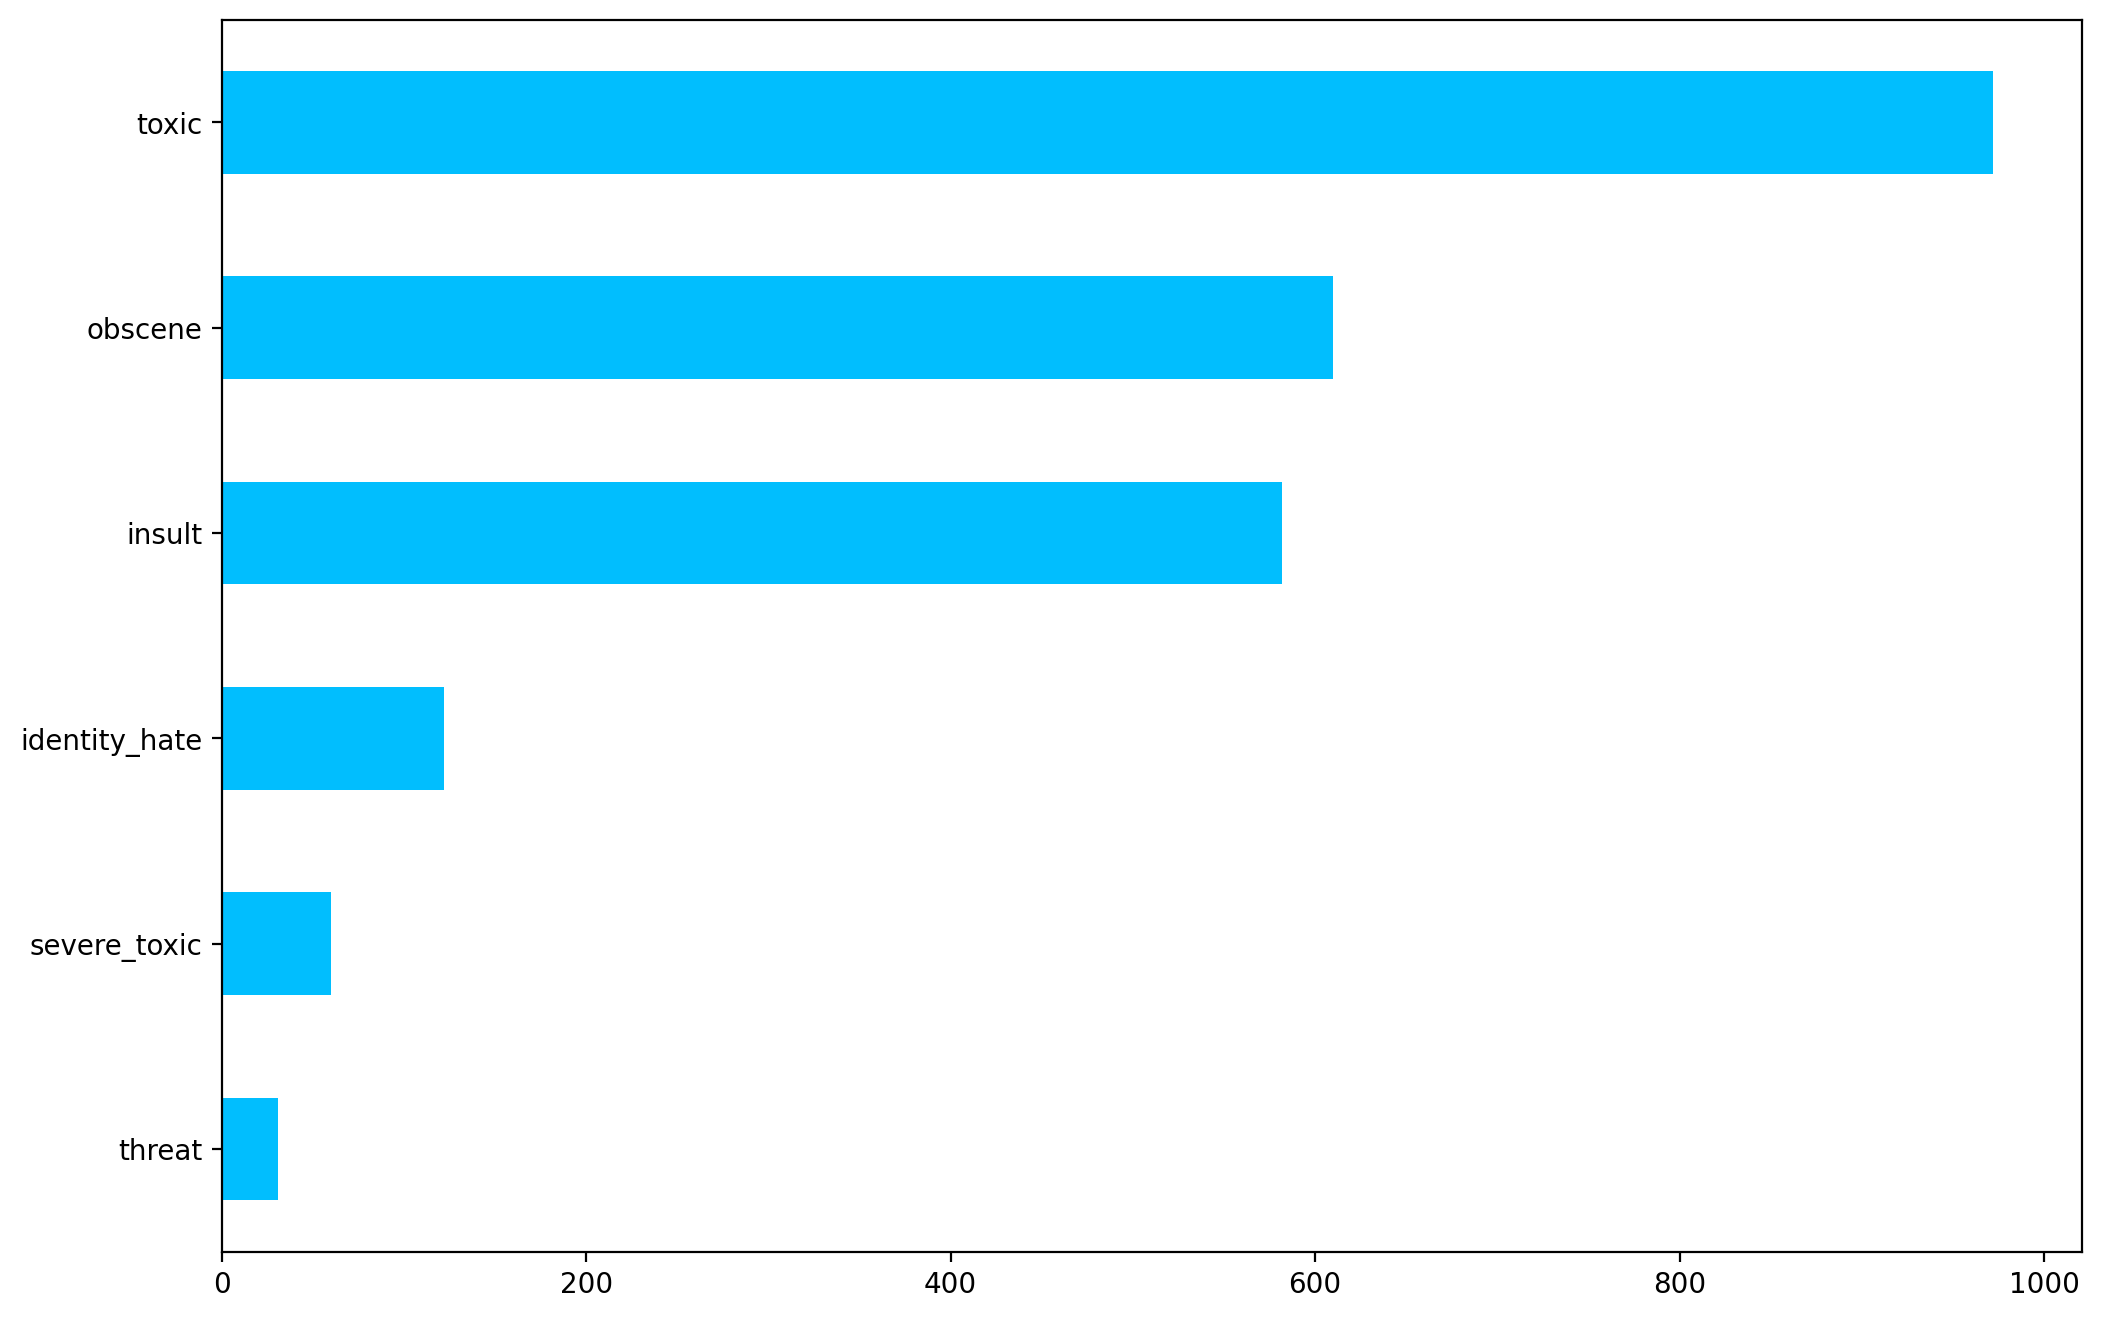

In [30]:
test_df.sample(10000, random_state=RANDOM_SEED)[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [31]:
test_df = test_df.sample(10000, random_state=RANDOM_SEED)

In [32]:
def random_loader(df, tokenizer, max_length=MAX_TOKEN_COUNT, batch_size=BATCH_SIZE):
    texts = df['comment_text'].tolist()
    labels = np.stack(df['one_hot_labels'].tolist())

    dataset = TextDataset(texts, labels, tokenizer, max_length)
    sampler = RandomSampler(dataset)

    loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size
    )

    return loader

test_dataloader = random_loader(test_df, tokenizer)

torch.save(test_dataloader, 'test_data_loader')

## Sample Weights
Sample weight are pasted as tensor, weights are made from Train data.

In [20]:
positive_counts = train_df[LABEL_COLUMNS].sum(axis=0)
total_instances = len(train_df)

pos_weight = total_instances / (positive_counts + 1e-5)  # Add a small value to prevent division by zero


pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)
pos_weight_tensor

tensor([ 5.4588, 54.0309,  9.7978, 91.5698, 10.4512, 59.3779])

# Roberta Model and Attributes
RoBERTa (Robustly Optimized BERT Pretraining Approach) for toxic comment classification was choosen for:
* Contextual Understanding: RoBERTa, being a transformer-based model.
* Pretraining: RoBERTa is pretrained on a large corpus with more data and for a longer time than BERT, giving it a better ability to handle complex language.
* Transfer Learning.


Model will be used for transfer learning. Key aspects of model:
* BCEWithLogitsLoss (Binary Cross Entropy with Logits Loss)
* Sigmoid Activation
* F1 optimization
* AdamW Optimizer

In [21]:
class ReBERTaClassifier(pl.LightningModule):
    def __init__(self, num_classes=6, class_weights=None, learning_rate=1e-5):
        super(ReBERTaClassifier, self).__init__()
        self.save_hyperparameters()

        print(f"Initializing ReBERTaClassifier with num_classes={num_classes}, "
              f"class_weights={'Provided' if class_weights is not None else 'None'}, "
              f"learning_rate={learning_rate}")

        if num_classes is None:
            raise ValueError("num_classes must be an integer representing the number of classes.")

        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = RobertaForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=self.num_classes,
            problem_type="multi_label_classification"  
        )

        if class_weights is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
            print(f"Using class_weights: {class_weights}")
        else:
            self.criterion = nn.BCEWithLogitsLoss()
            print("Using default BCEWithLogitsLoss without pos_weight.")


        self.train_f1 = F1Score(task='multilabel', num_labels=self.num_classes, average='macro', threshold=0.5)
        self.val_f1 = F1Score(task='multilabel', num_labels=self.num_classes, average='macro', threshold=0.5)
        self.test_precision = Precision(task='multilabel', num_labels=self.num_classes, average='macro', threshold=0.5)
        self.test_recall = Recall(task='multilabel', num_labels=self.num_classes, average='macro', threshold=0.5)
        self.test_f1 = F1Score(task='multilabel', num_labels=self.num_classes, average='macro', threshold=0.5)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        preds = torch.sigmoid(logits)
        f1 = self.train_f1(preds, labels.int())

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        preds = torch.sigmoid(logits)
        f1 = self.val_f1(preds, labels.int())

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        logits = self(input_ids, attention_mask)
        preds = torch.sigmoid(logits)

        self.test_precision.update(preds, labels.int())
        self.test_recall.update(preds, labels.int())
        self.test_f1.update(preds, labels.int())

        loss = self.criterion(logits, labels)
        self.log('test_loss', loss, on_epoch=True)

    def on_test_epoch_end(self):
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1 = self.test_f1.compute()

        self.log('test_precision', precision, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_f1', f1, prog_bar=True)

        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

In [24]:
model = ReBERTaClassifier(num_classes=6, class_weights=pos_weight_tensor)

logger = TensorBoardLogger("tb_logs", name="RoBERTa_MultiLabel")

early_stopping = EarlyStopping(
    monitor="val_f1",
    mode="max",
    patience=2,
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    verbose=True,
    dirpath="checkpoints",
    filename="best_model-{epoch:02d}-{val_f1:.2f}"
)

trainer = pl.Trainer(
    max_epochs=5,
    logger=logger,
    callbacks=[early_stopping, checkpoint_callback],
    log_every_n_steps=1,
    devices=1,
    accelerator='gpu',
    enable_progress_bar=True
)


Initializing ReBERTaClassifier with num_classes=6, class_weights=Provided, learning_rate=1e-05


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using class_weights: tensor([ 5.4588, 54.0309,  9.7978, 91.5698, 10.4512, 59.3779])


In [33]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                             | Params | Mode 
----------------------------------------------------------------------------
0 | model          | RobertaForSequenceClassification | 124 M  | eval 
1 | criterion      | BCEWithLogitsLoss                | 0      | train
2 | train_f1       | MultilabelF1Score                | 0      | train
3 | val_f1         | MultilabelF1Score                | 0      | train
4 | test_precision | MultilabelPrecision              | 0      | train
5 | test_recall    | MultilabelRecall                 | 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved. New best score: 0.477
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 2155: 'val_f1' reached 0.47719 (best 0.47719), saving model to '/content/checkpoints/best_model-epoch=00-val_f1=0.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved by 0.033 >= min_delta = 0.0. New best score: 0.510
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 4124: 'val_f1' reached 0.51018 (best 0.51018), saving model to '/content/checkpoints/best_model-epoch=01-val_f1=0.51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved by 0.005 >= min_delta = 0.0. New best score: 0.515
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 6093: 'val_f1' reached 0.51527 (best 0.51527), saving model to '/content/checkpoints/best_model-epoch=02-val_f1=0.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 8062: 'val_f1' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1 did not improve in the last 2 records. Best score: 0.515. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 10031: 'val_f1' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best run reached 52% F1 score. This is very close to ranndom guessing and is not good.

In [34]:
best_model = copy.deepcopy(model)

Testing on unseen data, overall F1 Score for not optimized threshold shows poor results, where F1 is 49%, but Recall is 86%. This means that model is biased towards predicting Toxic cases, leading to a large number of false positives

## Testing on unseen data

In [36]:
trainer.test(best_model, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.4938228130340576     │
│         test_loss         │    0.37268945574760437    │
│      test_precision       │    0.35240668058395386    │
│        test_recall        │    0.8665660619735718     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.37268945574760437,
  'test_precision': 0.35240668058395386,
  'test_recall': 0.8665660619735718,
  'test_f1': 0.4938228130340576}]

## Finding best Thresholds for each label

In [37]:
def find_best_thresholds(y_true, y_scores, num_classes, LABEL_COLUMNS):
    thresholds = np.linspace(0, 1, num=100)  
    best_thresholds = np.zeros(num_classes)
    best_f1_scores = np.zeros(num_classes)

    for label in range(num_classes):
        f1_scores = []

        for threshold in thresholds:
            preds = (y_scores[:, label] >= threshold).astype(int)
            f1 = f1_score(y_true[:, label], preds)
            f1_scores.append(f1)

        best_idx = np.argmax(f1_scores)
        best_thresholds[label] = thresholds[best_idx]
        best_f1_scores[label] = f1_scores[best_idx]

        print(f"Label '{LABEL_COLUMNS[label]}': Best Threshold = {best_thresholds[label]:.2f}, Best F1 Score = {best_f1_scores[label]:.2f}")

    return best_thresholds, best_f1_scores

def test_and_optimize_thresholds(trainer, model, test_loader, num_classes, LABEL_COLUMNS):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            logits = model(input_ids, attention_mask)
            preds = torch.sigmoid(logits)  

            all_preds.append(preds)
            all_labels.append(labels)

    y_scores = torch.cat(all_preds).cpu().numpy()
    y_true = torch.cat(all_labels).cpu().numpy()

    best_thresholds, best_f1_scores = find_best_thresholds(y_true, y_scores, num_classes, LABEL_COLUMNS)

    return best_thresholds

In [40]:
best_thresholds = test_and_optimize_thresholds(trainer, best_model, val_loader, num_classes=6, LABEL_COLUMNS = LABEL_COLUMNS)

np.save("best_thresholds.npy", best_thresholds)

Label 'toxic': Best Threshold = 0.78, Best F1 Score = 0.85
Label 'severe_toxic': Best Threshold = 0.93, Best F1 Score = 0.47
Label 'obscene': Best Threshold = 0.85, Best F1 Score = 0.85
Label 'threat': Best Threshold = 0.88, Best F1 Score = 0.74
Label 'insult': Best Threshold = 0.75, Best F1 Score = 0.76
Label 'identity_hate': Best Threshold = 0.87, Best F1 Score = 0.57


Optimal threshold for each label shows that all thresholds are increased, model is trying to accomodate being biased for toxic cases.

## ROC AUC curves per Label, with Thresholds

In [46]:
def plot_roc_curves(y_true, y_scores, LABEL_COLUMNS):
    """Plot ROC curves for each label."""
    plt.figure(figsize=(10, 8))

    for label in range(len(LABEL_COLUMNS)):
        if np.unique(y_true[:, label]).size == 2: 
            fpr, tpr, _ = roc_curve(y_true[:, label], y_scores[:, label])
            auc_score = roc_auc_score(y_true[:, label], y_scores[:, label])
            plt.plot(fpr, tpr, label=f'{LABEL_COLUMNS[label]} (AUC = {auc_score:.2f})')
        else:
            print(f"Skipping {LABEL_COLUMNS[label]}: Only one class present in y_true.")

    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Label Classification')
    plt.legend()
    plt.grid()
    plt.show()

def test_and_evaluate_roc_auc(trainer, model, test_loader, LABEL_COLUMNS):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            logits = model(input_ids, attention_mask)
            preds = torch.sigmoid(logits)  

            all_preds.append(preds)
            all_labels.append(labels)

    y_scores = torch.cat(all_preds).cpu().numpy()
    y_true = torch.cat(all_labels).cpu().numpy()

    plot_roc_curves(y_true, y_scores, LABEL_COLUMNS=LABEL_COLUMNS)

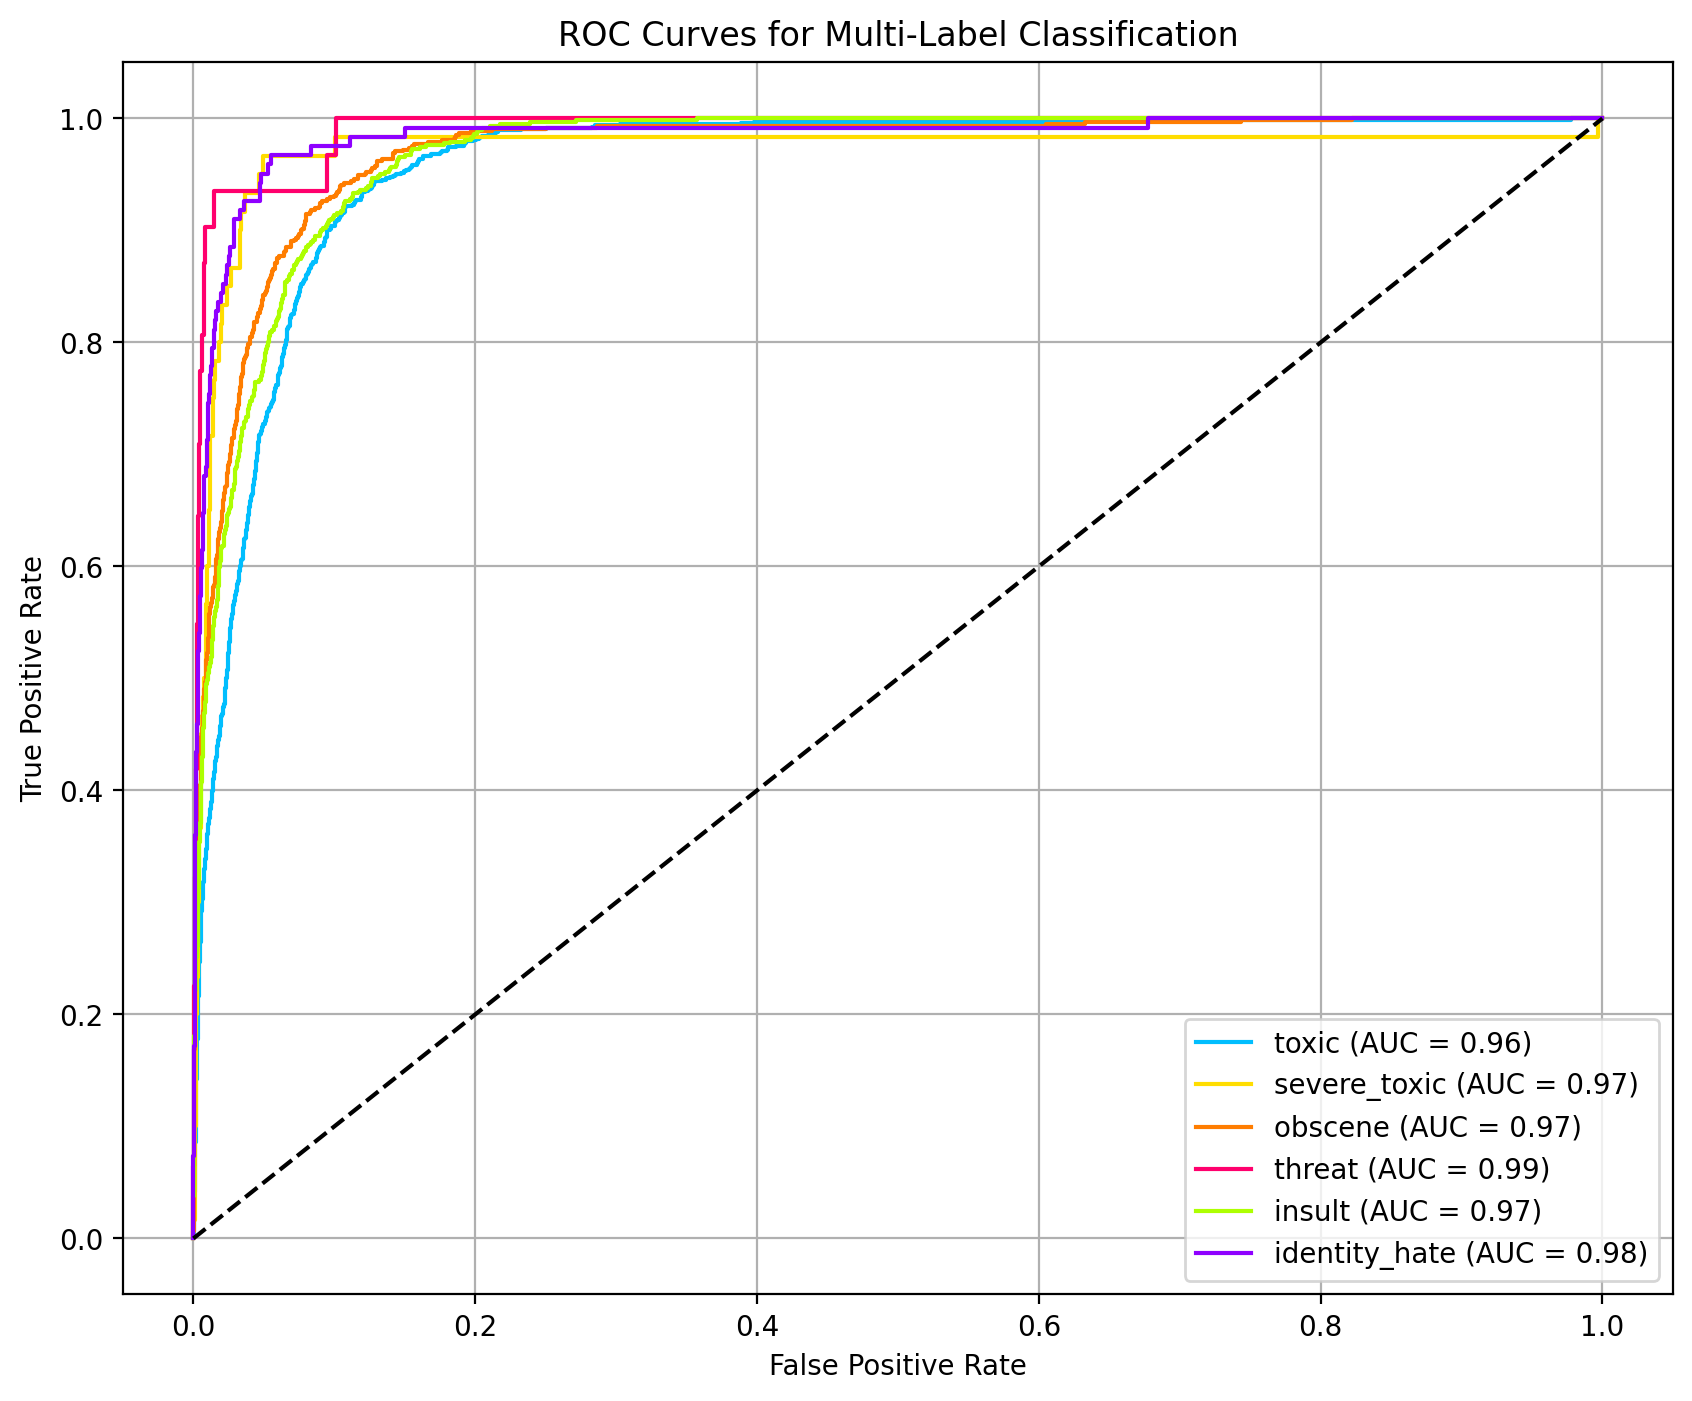

In [47]:
test_and_evaluate_roc_auc(trainer, best_model, test_dataloader, LABEL_COLUMNS=LABEL_COLUMNS)

## Metrics with label thresholds

In [48]:
def apply_thresholds(y_scores, thresholds):
    """Apply the optimized thresholds to the predicted probabilities."""
    return (y_scores >= thresholds).astype(int)

def calculate_metrics(y_true, y_pred):
    """Calculate F1, precision, and recall for each label."""
    f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_label = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_label = recall_score(y_true, y_pred, average=None, zero_division=0)

    return f1_per_label, precision_per_label, recall_per_label


def evaluate_metrics_per_label_with_thresholds(trainer, model, test_loader, best_thresholds, LABEL_COLUMNS):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            logits = model(input_ids, attention_mask)
            preds = torch.sigmoid(logits)  

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_scores = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    y_pred = apply_thresholds(y_scores, best_thresholds)

    f1_per_label, precision_per_label, recall_per_label = calculate_metrics(y_true, y_pred)

    metrics_df = pd.DataFrame({
        'Label': LABEL_COLUMNS,
        'F1 Score': f1_per_label,
        'Precision': precision_per_label,
        'Recall': recall_per_label
    })
    metrics_df.set_index('Label', inplace=True)


    plt.figure(figsize=(7, 6))
    sns.heatmap(metrics_df, annot=True)
    plt.title('Metric per Label')
    plt.show()

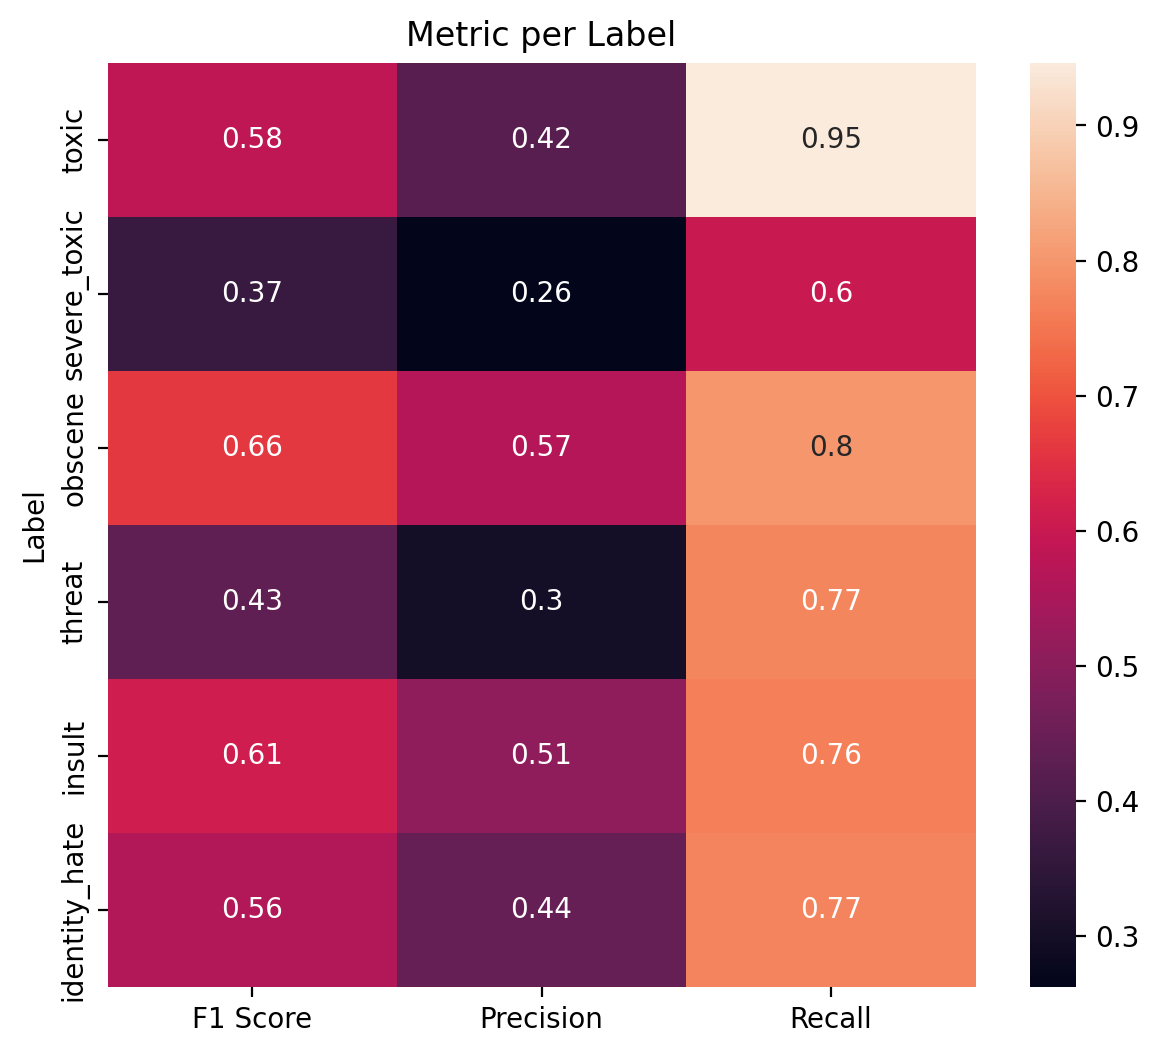

In [49]:
evaluate_metrics_per_label_with_thresholds(trainer, best_model, test_dataloader, best_thresholds, LABEL_COLUMNS=LABEL_COLUMNS)

Metrics still show model is biased in finding toxic cases, even with applied higher thresholds. Low count Labels (Threat, Severe Toxxic) gets lower scores as they are not expected. Thes rest Labels got 58-66% F1 Score.

# Conclusion
In this notebook, the Reboreta model was used for transfer learning. Some classes with the lowest amount of cases got no predictions from the model, while other categories got around 60% F1. Overall, the created model is not great, but would help filtering Obscene comments.